# XLM-RoBERTa Training for Multilingual Sentiment Analysis

This notebook trains XLM-RoBERTa on the English Financial PhraseBank dataset
and tests cross-lingual transfer to Spanish.

**Model:** `xlm-roberta-base` (270M parameters, 100+ languages)

## 1. Setup

In [2]:
import sys
import warnings
from pathlib import Path

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))
warnings.filterwarnings('ignore')

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config import XLM_ROBERTA_CONFIG, print_config, MODELS_DIR
from config.params import ID2LABEL
from src.data import load_financial_phrasebank, create_data_splits, create_dataloaders
from src.models import create_model, Trainer, ModelEvaluator, SentimentPredictor
from src.models.classifier import print_model_info

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce GTX 1660 SUPER
Memory: 6.4 GB


In [3]:
# Show configuration
print_config(XLM_ROBERTA_CONFIG)

Model Configuration: xlm-roberta
model_name.................... xlm-roberta
model_checkpoint.............. xlm-roberta-base
num_labels.................... 3
learning_rate................. 2e-05
batch_size.................... 16
num_epochs.................... 5
warmup_steps.................. 500
weight_decay.................. 0.01
max_seq_length................ 128
optimizer..................... adamw
scheduler..................... linear
patience...................... 3
min_delta..................... 0.001
dropout....................... 0.1
gradient_clip_norm............ 1.0
seed.......................... 42
device........................ cuda


## 2. Data Preparation

In [4]:
# Load dataset
print("Loading Financial PhraseBank...")
df = load_financial_phrasebank(agreement_level="sentences_75agree")
print(f"Total samples: {len(df)}")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

Loading Financial PhraseBank...
Total samples: 3453

Label distribution:
label
0     420
1    2146
2     887
Name: count, dtype: int64


In [5]:
# Create splits
print("Creating train/val/test splits...")
train_df, val_df, test_df = create_data_splits(df, seed=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Creating train/val/test splits...
Train: 2417, Val: 518, Test: 518


In [6]:
# Create DataLoaders with XLM-RoBERTa tokenizer
print("Creating DataLoaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_df, val_df, test_df,
    tokenizer_name=XLM_ROBERTA_CONFIG.model_checkpoint,
    batch_size=XLM_ROBERTA_CONFIG.batch_size,
    max_length=XLM_ROBERTA_CONFIG.max_seq_length,
    num_workers=0,  # Windows compatibility
    text_column='sentence'  # Column name in Financial PhraseBank
)
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Creating DataLoaders...
Train batches: 152, Val batches: 33, Test batches: 33


## 3. Model Training

In [7]:
# Create model
print("Creating XLM-RoBERTa model...")
model = create_model(
    model_checkpoint=XLM_ROBERTA_CONFIG.model_checkpoint,
    num_labels=3,
    device=device
)
print_model_info(model, "XLM-RoBERTa-base")

Creating XLM-RoBERTa model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MODEL INFORMATION: XLM-RoBERTa-base
Total parameters:     278,045,955
Trainable parameters: 278,045,955
Frozen parameters:    0
Model size (MB):      1060.66


In [8]:
# Create trainer
trainer = Trainer.from_config(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=XLM_ROBERTA_CONFIG,
    checkpoint_dir=str(MODELS_DIR / "xlm-roberta")
)

In [9]:
# Train!
print("Starting training...")
print("="*60)
history = trainer.train()

Starting training...


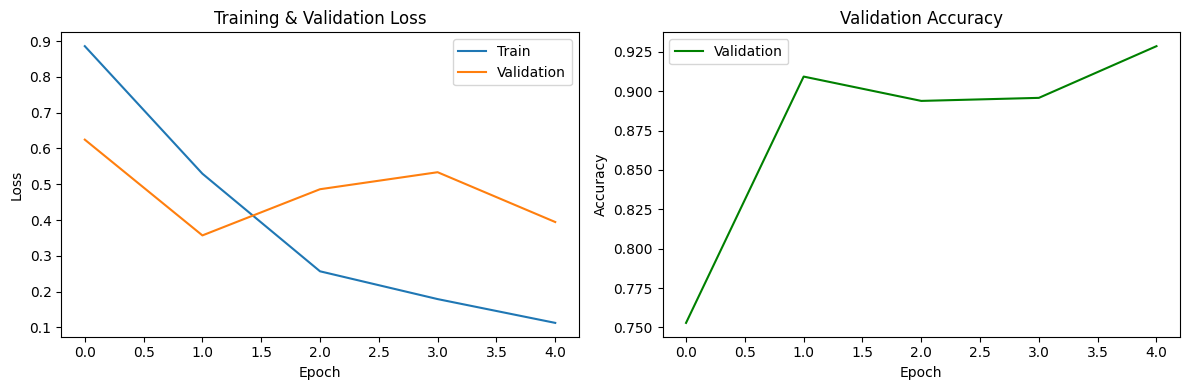


Best validation accuracy: 0.9286


In [10]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history.train_loss, label='Train')
axes[0].plot(history.val_loss, label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
# Accuracy
axes[1].plot(history.val_acc, label='Validation', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nBest validation accuracy: {max(history.val_acc):.4f}")

## 4. Evaluation on English Test Set

In [11]:
# Load best model
from src.models import load_model

best_model_path = MODELS_DIR / "xlm-roberta" / "best_model.pt"
model = load_model(
    checkpoint_path=str(best_model_path),
    model_checkpoint=XLM_ROBERTA_CONFIG.model_checkpoint,
    num_labels=3,
    device=device
)
print(f"Loaded best model from {best_model_path}")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded best model from C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\models\xlm-roberta\best_model.pt


In [12]:
# Evaluate on test set
from src.models.evaluator import evaluate_model_on_test

predictions, labels, probabilities = evaluate_model_on_test(model, test_loader, device=device)

evaluator = ModelEvaluator()
metrics = evaluator.compute_metrics(predictions, labels)

print("\n" + "="*60)
print("TEST SET RESULTS (English)")
print("="*60)
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"F1 Macro:  {metrics['f1_macro']:.4f}")
print(f"F1 Weighted: {metrics['f1_weighted']:.4f}")

Evaluating on test set: 100%|██████████| 33/33 [04:11<00:00,  7.62s/it]


TEST SET RESULTS (English)
Accuracy:  0.9170
F1 Macro:  0.8952
F1 Weighted: 0.9179


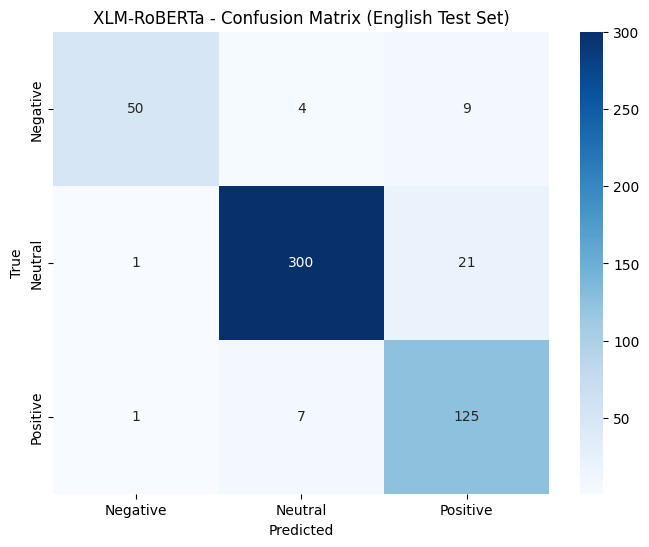


Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.79      0.87        63
     Neutral       0.96      0.93      0.95       322
    Positive       0.81      0.94      0.87       133

    accuracy                           0.92       518
   macro avg       0.91      0.89      0.90       518
weighted avg       0.92      0.92      0.92       518



In [13]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XLM-RoBERTa - Confusion Matrix (English Test Set)')
plt.show()

print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=['Negative', 'Neutral', 'Positive']))

## 5. Cross-lingual Testing (Spanish)

Test zero-shot transfer: model trained on English, tested on Spanish financial texts.

In [14]:
# Create predictor
predictor = SentimentPredictor(
    model_path=str(best_model_path),
    tokenizer_name=XLM_ROBERTA_CONFIG.model_checkpoint,
    device=device
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Spanish financial test sentences
spanish_texts = [
    # Positive
    ("Los ingresos de la empresa aumentaron un 25% en el tercer trimestre.", "positive"),
    ("La compañía reportó ganancias récord este año.", "positive"),
    ("Las acciones subieron tras el anuncio de dividendos.", "positive"),
    ("El nuevo producto superó las expectativas del mercado.", "positive"),
    ("La fusión generará sinergias significativas.", "positive"),
    
    # Negative
    ("La empresa anunció pérdidas significativas en el último trimestre.", "negative"),
    ("Las ventas cayeron un 15% debido a la competencia.", "negative"),
    ("El CEO renunció tras el escándalo financiero.", "negative"),
    ("La compañía recortará 500 empleos para reducir costos.", "negative"),
    ("Los inversores perdieron confianza en la gestión.", "negative"),
    
    # Neutral
    ("La empresa publicará sus resultados el próximo lunes.", "neutral"),
    ("El consejo de administración se reunirá mañana.", "neutral"),
    ("La compañía tiene sede en Madrid.", "neutral"),
    ("El informe anual estará disponible en línea.", "neutral"),
    ("La empresa opera en el sector tecnológico.", "neutral"),
]

print(f"Testing on {len(spanish_texts)} Spanish sentences...\n")

Testing on 15 Spanish sentences...



In [16]:
# Run predictions
results = []
for text, true_label in spanish_texts:
    pred = predictor.predict(text, return_probabilities=True)
    results.append({
        'text': text[:60] + '...' if len(text) > 60 else text,
        'true': true_label,
        'predicted': pred['prediction'],
        'confidence': pred['confidence'],
        'correct': pred['prediction'] == true_label
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                                                           text     true predicted  confidence  correct
Los ingresos de la empresa aumentaron un 25% en el tercer tr... positive  positive    0.662129     True
                 La compañía reportó ganancias récord este año. positive  positive    0.555986     True
           Las acciones subieron tras el anuncio de dividendos. positive  positive    0.638135     True
         El nuevo producto superó las expectativas del mercado. positive  positive    0.583985     True
                   La fusión generará sinergias significativas. positive  positive    0.517639     True
La empresa anunció pérdidas significativas en el último trim... negative  negative    0.808405     True
             Las ventas cayeron un 15% debido a la competencia. negative  negative    0.846466     True
                  El CEO renunció tras el escándalo financiero. negative  positive    0.397162    False
         La compañía recortará 500 empleos para reducir costos. 

In [17]:
# Calculate Spanish accuracy
spanish_accuracy = results_df['correct'].mean()
print(f"\n{'='*60}")
print(f"SPANISH ZERO-SHOT RESULTS")
print(f"{'='*60}")
print(f"Accuracy: {spanish_accuracy:.1%} ({results_df['correct'].sum()}/{len(results_df)})")
print(f"\nPer-class accuracy:")
for label in ['positive', 'neutral', 'negative']:
    subset = results_df[results_df['true'] == label]
    acc = subset['correct'].mean()
    print(f"  {label}: {acc:.1%} ({subset['correct'].sum()}/{len(subset)})")


SPANISH ZERO-SHOT RESULTS
Accuracy: 80.0% (12/15)

Per-class accuracy:
  positive: 100.0% (5/5)
  neutral: 100.0% (5/5)
  negative: 40.0% (2/5)


In [18]:
# Compare English vs Spanish
print(f"\n{'='*60}")
print("COMPARISON: English vs Spanish")
print(f"{'='*60}")
print(f"English test accuracy: {metrics['accuracy']:.1%}")
print(f"Spanish zero-shot:     {spanish_accuracy:.1%}")
print(f"Transfer efficiency:   {spanish_accuracy/metrics['accuracy']:.1%}")


COMPARISON: English vs Spanish
English test accuracy: 91.7%
Spanish zero-shot:     80.0%
Transfer efficiency:   87.2%


## 6. Interactive Demo

In [19]:
def analyze_sentiment(text: str):
    """Analyze sentiment of a text in any language."""
    result = predictor.predict(text, return_probabilities=True)
    print(f"Text: {text}")
    print(f"Sentiment: {result['prediction'].upper()}")
    print(f"Confidence: {result['confidence']:.1%}")
    probs = result['probabilities']
    print(f"Probabilities: neg={probs['negative']:.2f}, "
          f"neu={probs['neutral']:.2f}, "
          f"pos={probs['positive']:.2f}")
    print()

# Test with different languages
print("=" * 60)
print("MULTILINGUAL DEMO")
print("=" * 60 + "\n")

# English
analyze_sentiment("Revenue increased by 25% this quarter.")

# Spanish
analyze_sentiment("Los beneficios cayeron un 10% este año.")

# Russian (bonus test)
analyze_sentiment("Компания объявила о рекордной прибыли.")

MULTILINGUAL DEMO

Text: Revenue increased by 25% this quarter.
Sentiment: POSITIVE
Confidence: 64.3%
Probabilities: neg=0.17, neu=0.19, pos=0.64

Text: Los beneficios cayeron un 10% este año.
Sentiment: NEGATIVE
Confidence: 53.1%
Probabilities: neg=0.53, neu=0.10, pos=0.36

Text: Компания объявила о рекордной прибыли.
Sentiment: POSITIVE
Confidence: 55.5%
Probabilities: neg=0.12, neu=0.33, pos=0.56



In [20]:
# Try your own text!
# analyze_sentiment("Your text here in any language")